In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras import Sequential
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

### GPU Config

In [2]:
gpu_device = tf.config.experimental.list_physical_devices('GPU')
print(f"Number of GPU = {len(gpu_device)}")
tf.config.experimental.set_memory_growth(gpu_device[0], True)

Number of GPU = 1


In [3]:
#colab
'''
from google.colab import drive
drive.mount('/content/drive')
dataPath = '/content/drive/MyDrive/Faces'
'''

#local
dataPath = r'T:/CodeBase/Python/Computer Vision/MID/Project/FaceDetection/PreprocessedImg'
labels = ['Touhid','Tishad','Abir','Shimla']
imgSize = 64

In [4]:
for label in labels:
    classPath = os.path.join(dataPath, label)
    if not os.path.exists(classPath):
        print(f"Folder not found: {classPath}")
    else:
        print(f"Folder exists: {classPath}")

Folder exists: T:/CodeBase/Python/Computer Vision/MID/Project/FaceDetection/PreprocessedImg\Touhid
Folder exists: T:/CodeBase/Python/Computer Vision/MID/Project/FaceDetection/PreprocessedImg\Tishad
Folder exists: T:/CodeBase/Python/Computer Vision/MID/Project/FaceDetection/PreprocessedImg\Abir
Folder exists: T:/CodeBase/Python/Computer Vision/MID/Project/FaceDetection/PreprocessedImg\Shimla


In [5]:
def loadData(dataPath,labels,imgSize):
    data = []
    for label in labels:
        classPath = os.path.join(dataPath, label)
        classNum = labels.index(label)
        for img in tqdm(os.listdir(classPath), desc=f"Loading {label}"):
            try:
                imgPath = os.path.join(classPath, img)
                imgArray = cv2.imread(imgPath)
                imgArray = cv2.cvtColor(imgArray, cv2.COLOR_BGR2GRAY)
                imgResized = cv2.resize(imgArray,(imgSize,imgSize))
                data.append([imgResized,classNum])
            except Exception as e:
                print(f"Error loading image {img}: {e}")
    return data

In [6]:
trainData = loadData(dataPath,labels,imgSize)

Loading Shimla: 100%|██████████| 2000/2000 [00:00<00:00, 5404.51it/s]


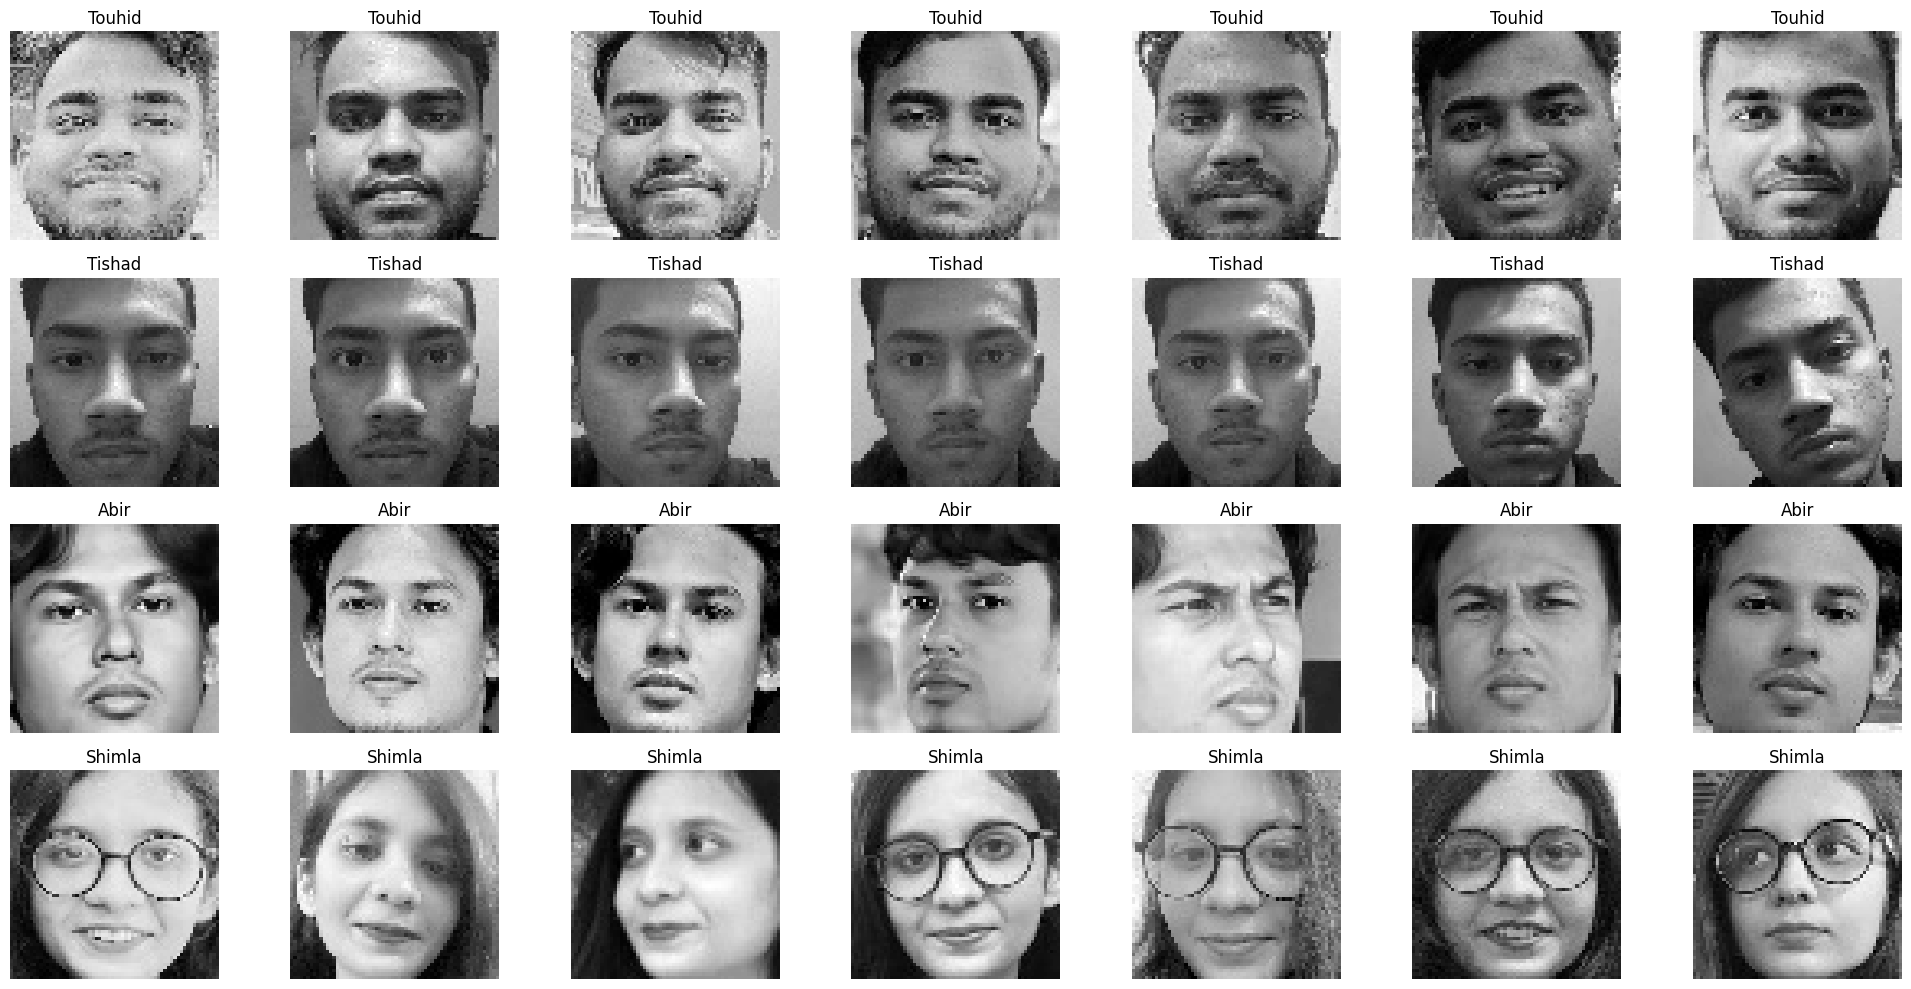

In [7]:
def sampleImages(data, labels,img_size,samples_per_class=7):
    plt.figure(figsize=(20, 10))
    for i, label in enumerate(labels):
        class_images = [img for img, lbl in data if lbl == i][:samples_per_class]
        for j, img in enumerate(class_images):
            plt.subplot(len(labels),samples_per_class,i * samples_per_class + j + 1)
            plt.imshow(img, cmap='gray')
            plt.axis('off')
            plt.title(label)
    plt.tight_layout()
    plt.show()

sampleImages(trainData,labels,imgSize,samples_per_class=7)

In [8]:
np.random.shuffle(trainData)
X, y = zip(*trainData)
X = np.array(X, dtype=np.float32) / 255.0  
y = np.array(y)

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training data shape: {X_train.shape}, Validation data shape: {X_val.shape}")

Training data shape: (6400, 64, 64), Validation data shape: (1600, 64, 64)


In [10]:
model = Sequential([
    layers.Input(shape=(imgSize,imgSize, 1)),
 
    layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu'),
    layers.BatchNormalization(), 
    layers.AveragePooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25), 

    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),

    layers.Dense(4, activation='softmax')  # 4 classes -> Tohid,Tishad,Abir,Shimla
])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 60, 32)        832       
                                                                 
 batch_normalization (BatchN  (None, 60, 60, 32)       128       
 ormalization)                                                   
                                                                 
 average_pooling2d (AverageP  (None, 30, 30, 32)       0         
 ooling2D)                                                       
                                                                 
 dropout (Dropout)           (None, 30, 30, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 64)       2

In [11]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [12]:
cb = EarlyStopping(monitor='val_loss', min_delta=0.02, patience=3, restore_best_weights=True)

h = model.fit(x=X_train, y=y_train, 
              epochs=30,
              validation_split=0.2,
              callbacks=[cb]
             )

Epoch 1/30
160/160 [==============================] - 18s 19ms/step - loss: 0.2383 - accuracy: 0.9221 - val_loss: 9.0065 - val_accuracy: 0.2469
Epoch 2/30
160/160 [==============================] - 3s 16ms/step - loss: 0.0753 - accuracy: 0.9754 - val_loss: 5.9802 - val_accuracy: 0.2531
Epoch 3/30
160/160 [==============================] - 2s 15ms/step - loss: 0.0453 - accuracy: 0.9854 - val_loss: 6.0675 - val_accuracy: 0.4250
Epoch 4/30
160/160 [==============================] - 2s 15ms/step - loss: 0.0428 - accuracy: 0.9900 - val_loss: 0.9134 - val_accuracy: 0.7125
Epoch 5/30
160/160 [==============================] - 2s 15ms/step - loss: 0.0252 - accuracy: 0.9924 - val_loss: 4.2654 - val_accuracy: 0.4977
Epoch 6/30
160/160 [==============================] - 2s 15ms/step - loss: 0.0283 - accuracy: 0.9908 - val_loss: 0.3322 - val_accuracy: 0.9055
Epoch 7/30
160/160 [==============================] - 2s 15ms/step - loss: 0.0179 - accuracy: 0.9947 - val_loss: 0.0443 - val_accuracy: 0.989

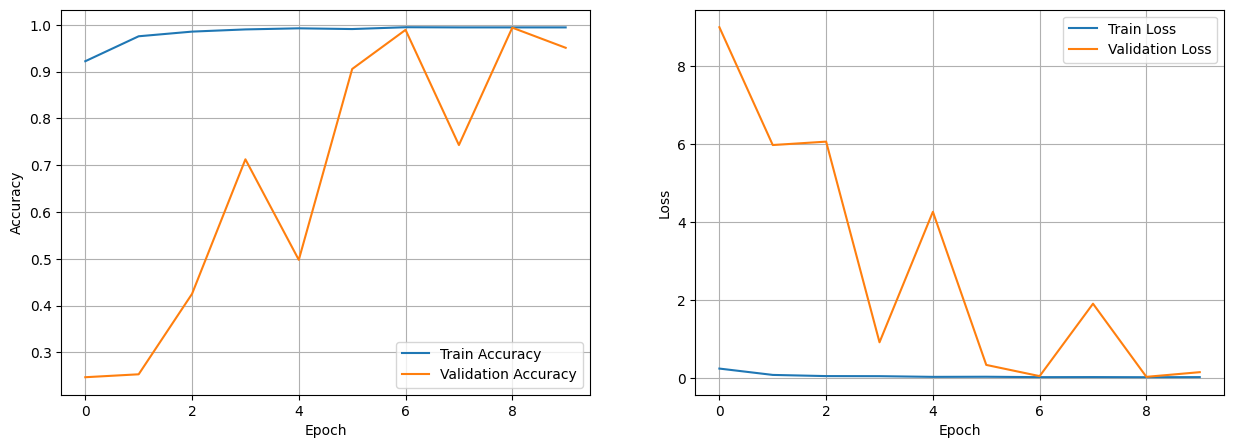

In [13]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(h.history['accuracy'], label='Train Accuracy')
plt.plot(h.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(h.history['loss'], label='Train Loss')
plt.plot(h.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [14]:
test_loss, test_acc = model.evaluate(X_val, y_val, verbose=2)
print(f"Validation Accuracy: {test_acc}, Validation Loss: {test_loss}")

50/50 - 0s - loss: 0.0704 - accuracy: 0.9856 - 251ms/epoch - 5ms/step
Validation Accuracy: 0.9856250286102295, Validation Loss: 0.07042011618614197


In [15]:
model.save("trainningCodeM.h5")